<a href="https://colab.research.google.com/github/aziztheiri/InsuranceClientSegmentation/blob/main/NewMLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [97]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Prevents column truncation

df = pd.read_csv('AutoInsurance.csv')
print(df.head())

  Customer       State  Customer Lifetime Value Response  Coverage Education Effective To Date EmploymentStatus Gender  Income Location Code Marital Status  Monthly Premium Auto  Months Since Last Claim  Months Since Policy Inception  Number of Open Complaints  Number of Policies     Policy Type        Policy Renew Offer Type Sales Channel  Total Claim Amount  Vehicle Class Vehicle Size
0  BU79786  Washington              2763.519279       No     Basic  Bachelor           2/24/11         Employed      F   56274      Suburban        Married                    69                       32                              5                          0                   1  Corporate Auto  Corporate L3           Offer1         Agent          384.811147   Two-Door Car      Medsize
1  QZ44356     Arizona              6979.535903       No  Extended  Bachelor           1/31/11       Unemployed      F       0      Suburban         Single                    94                       13                  

In [98]:
print(df.columns)


Index(['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage', 'Education', 'Effective To Date', 'EmploymentStatus', 'Gender', 'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size'], dtype='object')


In [99]:
df.info()
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [101]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0], "\n")


Series([], dtype: int64) 



In [102]:
num_duplicates = df.duplicated().sum()
print(num_duplicates, "\n")

0 



In [103]:
# Convertir 'Effective To Date' en datetime
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'])

# Extraire des features temporelles
df['Effective_Year'] = df['Effective To Date'].dt.year
df['Effective_Month'] = df['Effective To Date'].dt.month
df['Effective_Day'] = df['Effective To Date'].dt.day

# Supprimer la colonne datetime originale
df.drop('Effective To Date', axis=1, inplace=True)

<ipython-input-103-9b34c77278b7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Effective To Date'] = pd.to_datetime(df['Effective To Date'])


In [104]:
id_columns = ['Customer', 'Policy', 'Renew Offer Type']  # Ajoutez toutes les colonnes similaires

df_clean = df.drop(id_columns, axis=1)

In [105]:
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
print("Colonnes catégorielles détectées :\n", categorical_cols)
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)


Colonnes catégorielles détectées :
 ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']


In [106]:
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df_encoded[numeric_cols]

# Standardisation des variables numériques
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
print(df_encoded.columns)

Index(['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount', 'Effective_Year', 'Effective_Month', 'Effective_Day', 'State_California', 'State_Nevada', 'State_Oregon', 'State_Washington', 'Response_Yes', 'Coverage_Extended', 'Coverage_Premium', 'Education_College', 'Education_Doctor', 'Education_High School or Below', 'Education_Master', 'EmploymentStatus_Employed', 'EmploymentStatus_Medical Leave', 'EmploymentStatus_Retired', 'EmploymentStatus_Unemployed', 'Gender_M', 'Location Code_Suburban', 'Location Code_Urban', 'Marital Status_Married', 'Marital Status_Single', 'Policy Type_Personal Auto', 'Policy Type_Special Auto', 'Sales Channel_Branch', 'Sales Channel_Call Center', 'Sales Channel_Web', 'Vehicle Class_Luxury Car', 'Vehicle Class_Luxury SUV', 'Vehicle Class_SUV', 'Vehicle Class_Sports Car', 'Vehicle Class_Two-Door Car',
       'Vehicle Size_

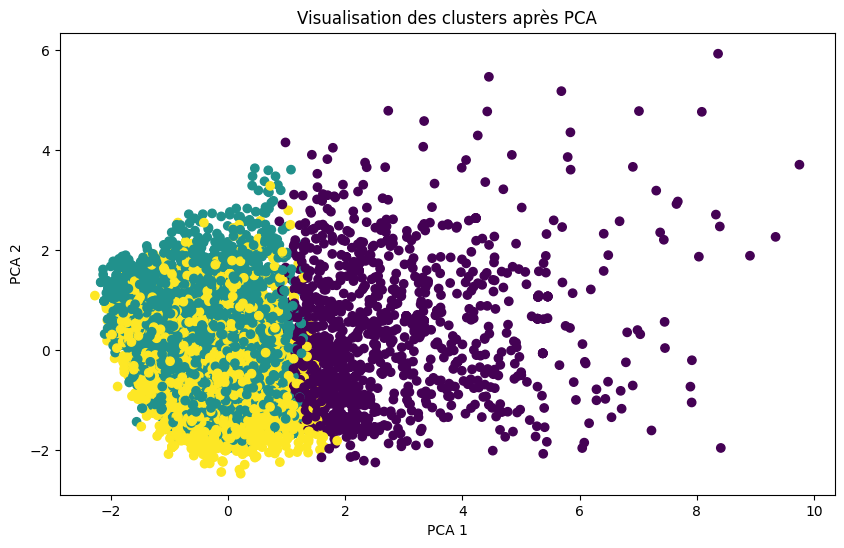

In [107]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_scaled)
# Clustering avec K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Ajout du cluster dans le DataFrame d'origine pour analyse
df_encoded['Cluster'] = clusters

# Visualisation des clusters avec les composantes PCA
plt.figure(figsize=(10, 6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualisation des clusters après PCA')
plt.show()

In [108]:
# Récupérer les centroïdes des clusters (dans l'espace scaled)
centroids_scaled = kmeans.cluster_centers_

# Transformer les centroïdes vers l'échelle originale
centroids_original = scaler.inverse_transform(centroids_scaled)

# Créer un DataFrame pour l'analyse
cluster_profile = pd.DataFrame(centroids_original, columns=df_numeric.columns)
cluster_profile["Taille_Cluster"] = df_encoded["Cluster"].value_counts().sort_index().values

print(cluster_profile)

   Customer Lifetime Value        Income  Monthly Premium Auto  Months Since Last Claim  Months Since Policy Inception  Number of Open Complaints  Number of Policies  Total Claim Amount  Taille_Cluster
0             16292.270944  24777.886199            151.179984                14.363196                      48.469734                   0.313963            2.867635          895.738795            1232
1              6617.337666  44217.256246             84.242952                 7.632821                      52.081366                   0.401329            2.703644          347.576592            4356
2              6811.879491  34072.145810             83.975368                24.574745                      42.960646                   0.388165            3.325028          379.011894            3546


In [109]:
# Ajouter la colonne Cluster au DataFrame original
df["Cluster"] = df_encoded["Cluster"]

# Maintenant l'analyse fonctionnera
for col in categorical_cols:
    print(f"\nDistribution de {col} par cluster :")
    print(df.groupby('Cluster')[col].value_counts(normalize=True).unstack().fillna(0))


Distribution de State par cluster :
State     Arizona  California    Nevada    Oregon  Washington
Cluster                                                      
0        0.178571    0.362013  0.095779  0.280032    0.083604
1        0.186410    0.342516  0.095960  0.287420    0.087695
2        0.189227    0.341794  0.097575  0.283136    0.088268

Distribution de Response par cluster :
Response        No       Yes
Cluster                     
0         0.868506  0.131494
1         0.851240  0.148760
2         0.859560  0.140440

Distribution de Coverage par cluster :
Coverage     Basic  Extended   Premium
Cluster                               
0         0.345779  0.399351  0.254870
1         0.662534  0.270432  0.067034
2         0.636210  0.302312  0.061478

Distribution de Education par cluster :
Education  Bachelor   College    Doctor  High School or Below    Master
Cluster                                                                
0          0.275974  0.286526  0.025974         

In [110]:
from sklearn.ensemble import RandomForestClassifier

# Récupérer toutes les features utilisées (numériques + dummies)
all_features = df_encoded.drop('Cluster', axis=1).columns

# Recréer X avec toutes les features
X_full = df_encoded.drop('Cluster', axis=1)
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

# Ré-entraîner le modèle
rf_full = RandomForestClassifier()
rf_full.fit(X_full_scaled, clusters)

# Nouvelle feature importance
feature_imp_full = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_full.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_imp_full.head(20))

                          Feature  Importance
3         Months Since Last Claim    0.478938
7              Total Claim Amount    0.107128
2            Monthly Premium Auto    0.084777
0         Customer Lifetime Value    0.066830
4   Months Since Policy Inception    0.037529
1                          Income    0.033653
6              Number of Policies    0.022218
10                  Effective_Day    0.015912
9                 Effective_Month    0.011650
37       Vehicle Class_Luxury SUV    0.009893
38              Vehicle Class_SUV    0.009581
36       Vehicle Class_Luxury Car    0.009379
22      EmploymentStatus_Employed    0.006565
27         Location Code_Suburban    0.006098
5       Number of Open Complaints    0.005830
25    EmploymentStatus_Unemployed    0.005621
17               Coverage_Premium    0.005606
26                       Gender_M    0.004951
15                   Response_Yes    0.004693
39       Vehicle Class_Sports Car    0.004539


In [111]:
selected_features = [
    'Months Since Last Claim',        # Importance: 47.6%
    'Total Claim Amount',             # Importance: 10.4%
    'Monthly Premium Auto',           # Importance: 8.7%
    'Customer Lifetime Value',        # Importance: 6.8%
    'Vehicle Class_Luxury Car',       # Importance: 0.98%
    'EmploymentStatus_Employed',      # Importance: 0.72%
    'Location Code_Suburban'          # Importance: 0.70%
]

In [112]:
X = df_encoded[selected_features]
y = clusters

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling pour SVM/KNN (pas nécessaire pour Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialisation des modèles
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', C=1, gamma='scale'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Entraînement et évaluation
results = {}
for name, model in models.items():
    if name in ['SVM', 'KNN']:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, pred)
    results[name] = accuracy

# Affichage des résultats
print("Comparaison des performances :")
for model, acc in results.items():
    print(f"{model}: {acc:.3f}")

Comparaison des performances :
Random Forest: 0.936
SVM: 0.934
KNN: 0.933


In [113]:
from joblib import dump

# Après l'entraînement du modèle
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Sauvegarde
dump(rf, 'random_forest_model.pkl')  # Crée le fichier .pkl

['random_forest_model.pkl']

In [114]:
# Charger le modèle pré-entraîné
import joblib
model = joblib.load('random_forest_model.pkl')  # Remplacez par votre modèle sauvegardé

# Prédiction pour tous les clients existants
df['Predicted_Cluster'] = model.predict(df_encoded[selected_features])

# Afficher le résultat
print(df[['Customer', 'Predicted_Cluster']].head(10))

  Customer  Predicted_Cluster
0  BU79786                  2
1  QZ44356                  0
2  AI49188                  2
3  WW63253                  2
4  HB64268                  1
5  OC83172                  1
6  XZ87318                  1
7  CF85061                  1
8  DY87989                  2
9  BQ94931                  2


In [115]:
def predict_cluster(new_data):
    # Préprocessing identique à l'entraînement
    new_data = new_data[selected_features]  # Sélection des features

    # Prédiction
    cluster = model.predict(new_data)[0]

    # Interprétation
    cluster_profiles = {
        0: "Jeunes clients à fort potentiel (CLV élevé)",
        1: "Clients établis haut revenu",
        2: "Clients premium véhicules de luxe"
    }
    return cluster, cluster_profiles[cluster]

# Exemple d'utilisation
new_client = pd.DataFrame([{
    'Months Since Last Claim': 2,
    'Total Claim Amount': 1200,
    'Monthly Premium Auto': 150,
    'Customer Lifetime Value': 21000,
    'Vehicle Class_Luxury Car': 1,
    'EmploymentStatus_Employed': 1,
    'Location Code_Suburban': 1
}])

cluster, interpretation = predict_cluster(new_client)
print(f"Cluster: {cluster} - {interpretation}")

Cluster: 0 - Jeunes clients à fort potentiel (CLV élevé)


In [116]:
!pip install flask-ngrok


In [117]:
pip install pyngrok


In [118]:
!ngrok authtoken '2Yj1IQVh4V0mntPyVDBTBW4oGYH_5JJWBTrkkiARCXP8z7HBu'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [119]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd
from pyngrok import ngrok

app = Flask(__name__)

# Charger le modèle NON SCALÉ
model = joblib.load('random_forest_model.pkl')

selected_features = [
    'Months Since Last Claim',
    'Total Claim Amount',
    'Monthly Premium Auto',
    'Customer Lifetime Value',
    'Vehicle Class_Luxury Car',  # Doit être exactement 0 ou 1
    'EmploymentStatus_Employed',
    'Location Code_Suburban'
]

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Convertir le JSON en DataFrame
        data = request.json
        df = pd.DataFrame(data)

        # Vérification des types de données
        df = df.astype({
            'Months Since Last Claim': 'int64',
            'Total Claim Amount': 'float64',
            'Monthly Premium Auto': 'int64',
            'Customer Lifetime Value': 'float64',
            'Vehicle Class_Luxury Car': 'int',
            'EmploymentStatus_Employed': 'int',
            'Location Code_Suburban': 'int'
        })

        # Vérification finale des features
        missing = set(selected_features) - set(df.columns)
        if missing:
            return jsonify({"error": f"Colonnes manquantes: {list(missing)}"}), 400

        # PRÉDICTION DIRECTE SANS SCALING
        predictions = model.predict(df[selected_features])

        # Formatage réponse
        results = [{
            "id": i,
            "cluster": int(pred),
            "features": df.iloc[i].to_dict()
        } for i, pred in enumerate(predictions)]

        return jsonify(results)

    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    ngrok.set_auth_token('2Yj1IQVh4V0mntPyVDBTBW4oGYH_5JJWBTrkkiARCXP8z7HBu')
    public_url = ngrok.connect(5000).public_url
    print(f"API URL: {public_url}/predict")
    app.run(host='0.0.0.0', port=5000)

API URL: https://3e27-35-185-70-119.ngrok-free.app/predict
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 12:12:42] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 12:13:53] "POST /predict HTTP/1.1" 200 -
